In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

import datetime
import os

import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
from shapely.geometry import Polygon

from eolearn.core import (
    AddFeatureTask,
    EONode,
    EOPatch,
    EOTask,
    EOWorkflow,
    FeatureType,
    LoadTask,
    OverwritePermission,
    SaveTask,
)
from eolearn.io import SentinelHubInputTask
from sentinelhub import DataCollection, SHConfig, UtmZoneSplitter

In [2]:
config = SHConfig()
config.sh_client_id = "4ef81af3-fb25-487a-bf45-9f11a204b025"  # Provide your client id
config.sh_client_secret = "8tDf1jCfegLvV0Iasa4NE8bFE38aOlfB"  # Provide your client secret
config.save()

In [3]:
import geopandas as gpd

# Path to the GeoPackage file
geo_file = "gadm41_PNG.gpkg"

# List all layers in the GeoPackage
layers = gpd.io.file.fiona.listlayers(geo_file)
print(layers)

['ADM_ADM_0', 'ADM_ADM_1', 'ADM_ADM_2', 'gadm41_PNG']


In [4]:
geo_file = "gadm41_PNG.gpkg"

aoi_gdf = gpd.read_file(geo_file, layer= 'ADM_ADM_2')
aoi = aoi_gdf.geometry[0]
aoi_crs = aoi_gdf.crs

/home1/10023/faithweichh/.local/lib/python3.7/site-packages/geopandas/plotting.py:51: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:


(140.03063582295013,
 157.8476450560501,
 -12.200357349999981,
 -0.21085564999993656)

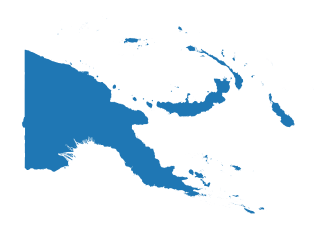

In [5]:
res = gpd.read_file(geo_file)
res.plot()
plt.axis("off")

In [34]:
###organizes the resulting information int a geodataframe, then saves as a geopackage file.
###This process manages large scale geographic data by dividing it into manageable chunks. 

# Create a splitter to obtain a list of bboxes with 5km sides
bbox_splitter = UtmZoneSplitter([aoi], aoi_crs, 5000)

bbox_list = np.array(bbox_splitter.get_bbox_list())
info_list = np.array(bbox_splitter.get_info_list())

# Prepare info of selected EOPatches
geometry = [Polygon(bbox.get_polygon()) for bbox in bbox_list]
idxs = [info["index"] for info in info_list]
idxs_x = [info["index_x"] for info in info_list]
idxs_y = [info["index_y"] for info in info_list]

bbox_gdf = gpd.GeoDataFrame(
    {"index": idxs, "index_x": idxs_x, "index_y": idxs_y}, crs="EPSG:32756", geometry=geometry
).to_crs("EPSG:32756")

# Save to shapefile
bbox_gdf.to_file(os.path.join(".", "grid_kl_500x500.gpkg"), driver="GPKG")

/home1/10023/faithweichh/.local/lib/python3.7/site-packages/sentinelhub/constants.py:126: SHUserWarning: sentinelhub-py supports only WGS 84 coordinate reference system with coordinate order lng-lat. Given pyproj.CRS(4326) has coordinate order lat-lng. Be careful to use the correct order of coordinates.
  warnings.warn(message, category=SHUserWarning)


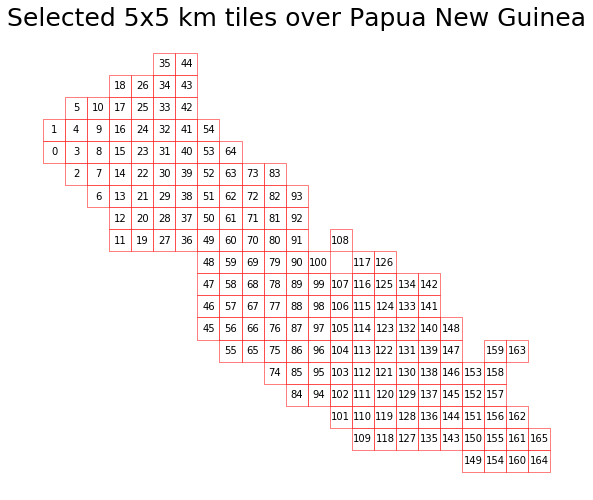

In [35]:
# Display bboxes over the Area of Interest
bbox_gdf = gpd.read_file(os.path.join(".", "grid_kl_500x500.gpkg"))
fig, ax = plt.subplots(figsize=(10, 10))
ax.set_title("Selected 5x5 km tiles over Papua New Guinea", fontsize=25)
bbox_gdf.plot(ax=ax, facecolor="w", edgecolor="r", alpha=0.5)

for bbox, info in zip(bbox_list, info_list):
    geo = bbox.geometry
    ax.text(geo.centroid.x, geo.centroid.y, info["index"], ha="center", va="center")
plt.axis("off");

In [36]:
download_task = SentinelHubInputTask(
    data_collection=DataCollection.SENTINEL2_L2A,
    bands_feature=(FeatureType.DATA, "BANDS"),
    resolution=10,
    time_difference=datetime.timedelta(minutes=120),
    maxcc=0.2,
    bands_dtype=np.uint16,
    bands=["B02", "B03", "B04", "B08"],
    config=config,
)

In [37]:
save_task = SaveTask("./EOPatches", overwrite_permission=OverwritePermission.OVERWRITE_PATCH)

In [38]:
# Setup the nodes
download_node = EONode(download_task)
save_node = EONode(save_task, inputs=[download_node])

# Define the workflow
workflow = EOWorkflow([download_node, save_node])

In [39]:
class ScaleImageTask(EOTask):
    def __init__(self):
        super().__init__()

    def process_image(self, image):
        img = np.clip(image[:, :, :, :3], a_min=0, a_max=1500)
        img = img / 1500 * 255
        img = np.concatenate((img, image[:, :, :, 3][..., None]), axis=-1)
        img = img.astype(np.uint8)
        return img

    def execute(self, eopatch):
        image = eopatch[FeatureType.DATA]["BANDS"]
        scaled_image = self.process_image(image)
        eopatch[FeatureType.DATA]["SCALED_BANDS"] = scaled_image

        return eopatch


scale_image_task = ScaleImageTask()

download_node_with_scale = EONode(download_task)
scale_node = EONode(scale_image_task, inputs=[download_node_with_scale])
save_node_with_scale = EONode(save_task, inputs=[scale_node])

workflow_with_scale = EOWorkflow([download_node_with_scale, scale_node, save_node_with_scale])

In [43]:
# Run the workflow over selected patches only instead of the complete AOI
TILE_IDS = [
    107,
    116,
    125,
    134,
    142,
    98,
    106,
    115,
    124,
    133,
]

for idx in TILE_IDS:
    result = workflow.execute(
        {
            download_node: {"bbox": bbox_list[idx], "time_interval": ["2021-07-01", "2021-09-30"]},
            save_node: {"eopatch_folder": f"eopatch_{idx}"},
        }
    )

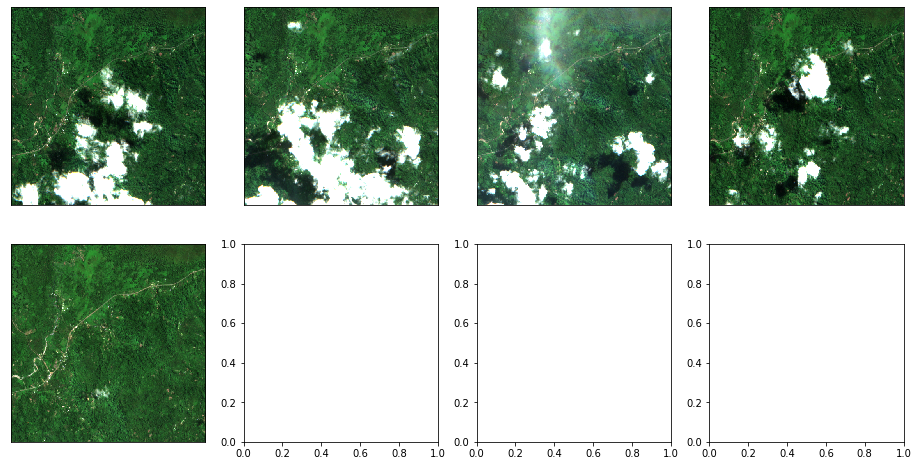

In [44]:
eopatch = EOPatch.load("./EOPatches/eopatch_106")
scaled_image = eopatch[FeatureType.DATA]["BANDS"]

img = np.clip(scaled_image[:, :, :, :3], a_min=0, a_max=1500)
img = img / 1500 * 255
img = np.concatenate((img, scaled_image[:, :, :, 3][..., None]), axis=-1)

fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(16, 8))
for i in range(len(img)):
    img = img.astype(np.uint8)
    ax = axs[i // 4][i % 4]
    ax.imshow(img[i][..., [2, 1, 0]])
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_aspect("auto")

In [45]:
###Starting machne learning section


import torch
import torch.nn as nn

In [46]:
class ConvLSTMCell(nn.Module):
    def __init__(self, input_size, input_dim, hidden_dim, kernel_size, bias):
        super(ConvLSTMCell, self).__init__()

        self.height, self.width = input_size
        self.i_dim = input_dim
        self.h_dim = hidden_dim

        self.kernel_size = kernel_size
        self.padding = kernel_size[0] // 2, kernel_size[1] // 2
        self.bias = bias

        self.conv = nn.Conv2d(
            in_channels=self.i_dim + self.h_dim,
            out_channels=4 * self.h_dim,
            kernel_size=self.kernel_size,
            padding=self.padding,
            bias=self.bias,
        )

    def forward(self, input_tensor, cur_state):
        h_cur, c_cur = cur_state

        combined = torch.cat([input_tensor, h_cur], dim=1)

        combined_conv = self.conv(combined)
        cc_i, cc_f, cc_o, cc_g = torch.split(combined_conv, self.h_dim, dim=1)
        i = torch.sigmoid(cc_i)
        f = torch.sigmoid(cc_f)
        o = torch.sigmoid(cc_o)
        g = torch.tanh(cc_g)

        c_next = f * c_cur + i * g
        h_next = o * torch.tanh(c_next)
        return h_next, c_next


class ConvLSTM(torch.nn.Module):
    def __init__(self, height, width, input_dim=13, hidden_dim=16, nclasses=4, kernel_size=(3, 3), bias=False):
        super(ConvLSTM, self).__init__()

        self.inconv = torch.nn.Conv3d(input_dim, hidden_dim, (1, 3, 3))

        self.cell = ConvLSTMCell(
            input_size=(height, width), input_dim=hidden_dim, hidden_dim=hidden_dim, kernel_size=kernel_size, bias=bias
        )

        self.final = torch.nn.Conv2d(hidden_dim, nclasses, (3, 3))

    def forward(self, x, hidden=None, state=None):
        x = x.permute(0, 4, 1, 2, 3)
        x = torch.nn.functional.pad(x, (1, 1, 1, 1), "constant", 0)
        x = self.inconv.forward(x)

        b, c, t, h, w = x.shape
        if hidden is None:
            hidden = torch.zeros((b, c, h, w))
        if state is None:
            state = torch.zeros((b, c, h, w))

        if torch.cuda.is_available():
            hidden = hidden.cuda()
            state = state.cuda()

        for iter in range(t):
            hidden, state = self.cell.forward(x[:, :, iter, :, :], (hidden, state))

        x = torch.nn.functional.pad(state, (1, 1, 1, 1), "constant", 0)
        x = self.final.forward(x)

        return x 

In [17]:
def convlstm(num_classes=3, in_channels=4):
    return ConvLSTM(
        512, 512, input_dim=in_channels, hidden_dim=24, nclasses=num_classes, kernel_size=(3, 3), bias=False
    )

In [18]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")
else:
    device = torch.device("cpu")

In [47]:
class InferenceTask(EOTask):
    def __init__(self, model_file):
        self.model = convlstm(num_classes=4, in_channels=4).to(device)
        self.model.load_state_dict(torch.load(model_file, map_location=device))
        self.model.eval()
        self.add_output = AddFeatureTask((FeatureType.MASK_TIMELESS, "mask"))

    def execute(self, eopatch):
        image = eopatch[FeatureType.DATA]["BANDS"]
        image = np.array(image, dtype=np.float32)
        image /= 65535.0

        image = torch.Tensor(image).unsqueeze(0).to(device)

        output = self.model(image)
        output = torch.argmax(output, dim=1)
        output = output.squeeze(0).unsqueeze(-1).cpu().numpy()

        eopatch = self.add_output(eopatch, output)

        return eopatch

In [48]:
model_file = "vi_forest_model_weights.pth"
inference_task = InferenceTask(model_file)

In [49]:
save_inference_task = SaveTask("./Predictions", overwrite_permission=OverwritePermission.OVERWRITE_PATCH)

In [50]:
load_node = EONode(LoadTask("./EOPatches"))
inference_node = EONode(inference_task, inputs=[load_node])
save_inference_node = EONode(save_inference_task, inputs=[inference_node])

inference_workflow = EOWorkflow([load_node, inference_node, save_inference_node])

In [51]:
TILE_IDS = [
    107,
    116,
    125,
    134,
    142,
    98,
    106,
    115,
    124,
    133,
]

In [52]:
for tile_id in TILE_IDS:
    inference_workflow.execute(
        {
            load_node: {"eopatch_folder": f"eopatch_{tile_id}"},
            save_inference_node: {"eopatch_folder": f"eopatch_{tile_id}"},
        }
    )

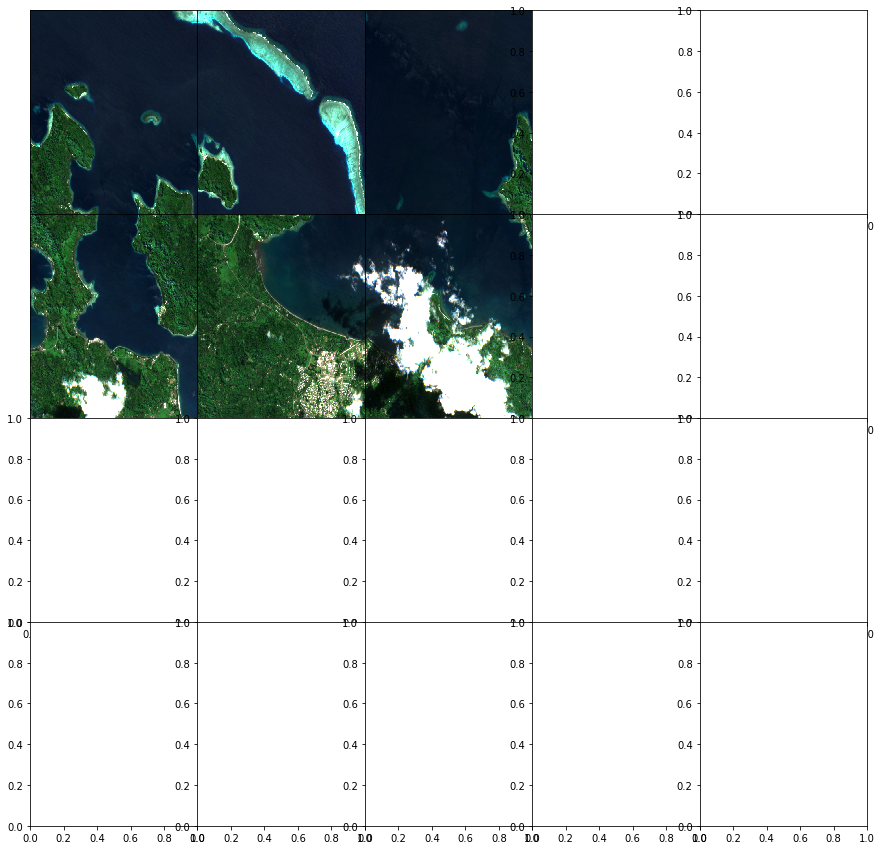

In [63]:
####Visualizing model predictions for area
fig, axs = plt.subplots(nrows=4, ncols=5, figsize=(15, 15))

for i, tile_id in enumerate(TILE_IDS):
    eopatch = EOPatch.load(f"./EOPatches/eopatch_{tile_id}")
    scaled_image = eopatch[FeatureType.DATA]["BANDS"]
    img = np.clip(scaled_image[:, :, :, :3], a_min=0, a_max=1500)
    img = img / 1500 * 255
    img = np.concatenate((img, scaled_image[:, :, :, 3][..., None]), axis=-1)
    img = img.astype(np.uint8)

    ax = axs[i // 5][i % 3]
    ax.imshow(img[0][..., [2, 1, 0]])
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_aspect("auto")

fig.subplots_adjust(wspace=0, hspace=0)

In [26]:
COLOR_ENCODING = {
    0: [255, 255, 255],
    1: [70, 158, 74],
    2: [28, 92, 36],
    3: [255, 255, 255],
}


def labelVisualize(img, num_class=3):
    img = img[:, :, 0] if len(img.shape) == 3 else img
    img_out = np.zeros(img.shape + (3,))
    for i in range(num_class):
        img_out[img == i, :] = COLOR_ENCODING[i]
    return img_out.astype(np.uint8)

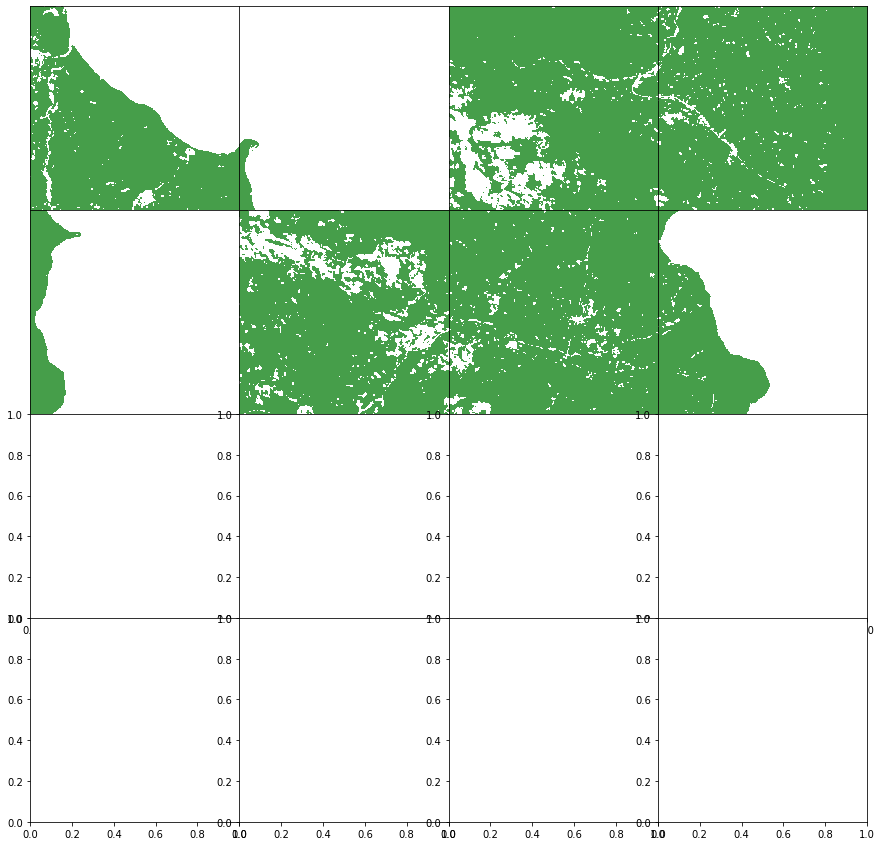

In [27]:
fig, axs = plt.subplots(nrows=4, ncols=4, figsize=(15, 15))
for i, tile_id in enumerate(TILE_IDS):
    inferenced_eopatch = EOPatch.load(f"./Predictions/eopatch_{tile_id}")
    output = inferenced_eopatch[FeatureType.MASK_TIMELESS]["mask"].squeeze(-1)
    output[output == 2] = 1
    output = labelVisualize(output)
    ax = axs[i // 4][i % 4]
    ax.imshow(output)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_aspect("auto")

fig.subplots_adjust(wspace=0, hspace=0)

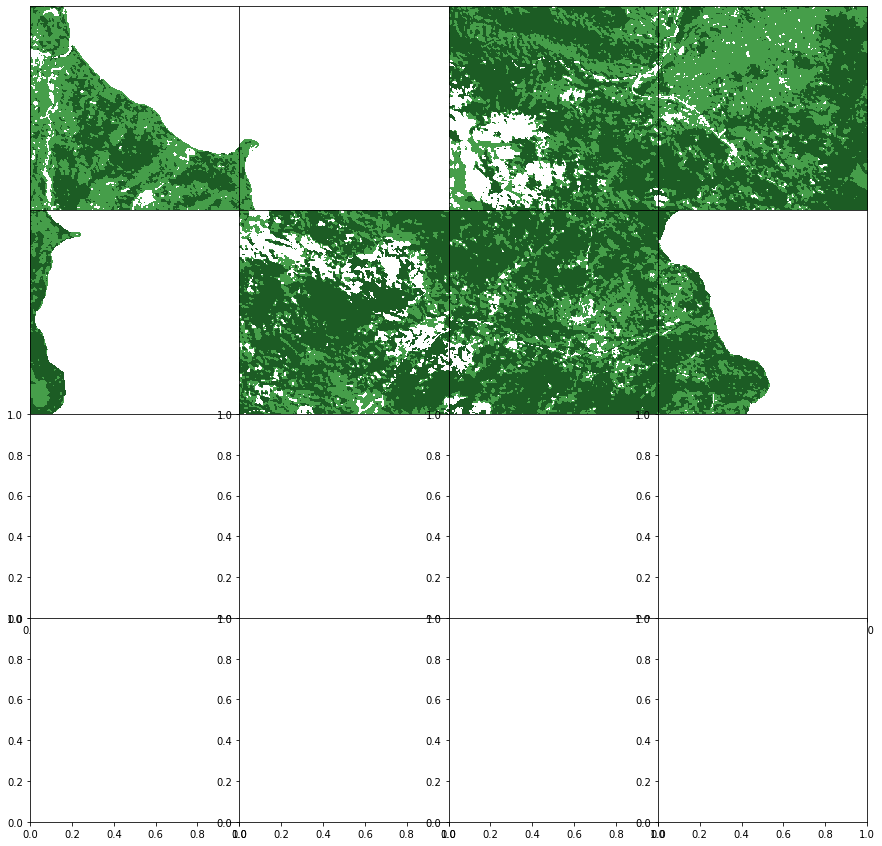

In [28]:
fig, axs = plt.subplots(nrows=4, ncols=4, figsize=(15, 15))
for i, tile_id in enumerate(TILE_IDS):
    inferenced_eopatch = EOPatch.load(f"./Predictions/eopatch_{tile_id}")
    output = inferenced_eopatch[FeatureType.MASK_TIMELESS]["mask"].squeeze(-1)
    output = labelVisualize(output)
    ax = axs[i // 4][i % 4]
    ax.imshow(output)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_aspect("auto")

fig.subplots_adjust(wspace=0, hspace=0)

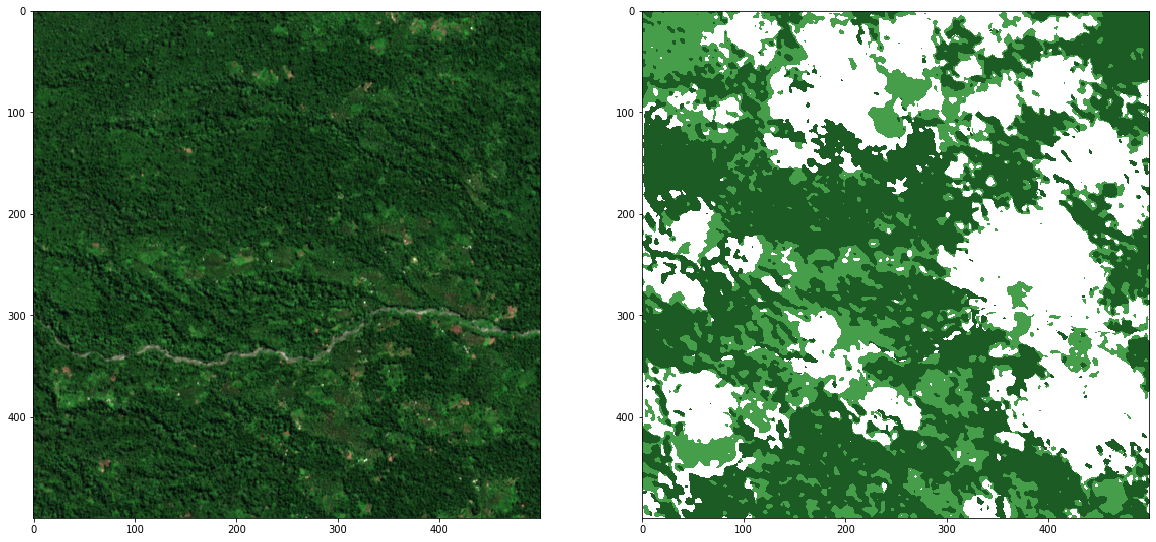

In [33]:
eopatch = EOPatch.load("./EOPatches/eopatch_70")
scaled_image = eopatch[FeatureType.DATA]["BANDS"]
img = np.clip(scaled_image[:, :, :, :3], a_min=0, a_max=1500)
img = img / 1500 * 255
img = np.concatenate((img, scaled_image[:, :, :, 3][..., None]), axis=-1)
img = img.astype(np.uint8)

inferenced_eopatch = EOPatch.load("./Predictions/eopatch_70")
output = inferenced_eopatch[FeatureType.MASK_TIMELESS]["mask"].squeeze(-1)
output = labelVisualize(output)

fig, ax = plt.subplots(1, 2, figsize=(20, 20))
ax[0].imshow(img[0][..., [2, 1, 0]])
ax[1].imshow(output);